<a href="https://colab.research.google.com/github/Sergey-Kiselev-dev/ML_sem_pub/blob/main/ML_05_mit_idl_lab01_01d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright Information
============
Copyright 2020 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.

Licensed under the MIT License. You may not use this file except in compliance
with the License. Use and/or modification of this code outside of 6.S191 must
reference:

© MIT 6.S191: Introduction to Deep Learning
http://introtodeeplearning.com

1.4 Automatic differentiation in TensorFlow
------------
Automatic differentiation is one of the most important parts of TensorFlow and is the backbone of training with backpropagation. We will use the TensorFlow GradientTape tf.GradientTape to trace operations for computing gradients later.

When a forward pass is made through the network, all forward-pass operations get recorded to a "tape"; then, to compute the gradient, the tape is played backwards. By default, the tape is discarded after it is played backwards; this means that a particular tf.GradientTape can only compute one gradient, and subsequent calls throw a runtime error. However, we can compute multiple gradients over the same computation by creating a persistent gradient tape.

First, we will look at how we can compute gradients using GradientTape and access them for computation. We define the simple function
 and compute the gradient:

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
### Gradient computation with GradientTape ###

# y = x^2
# Example: x = 3.0
x = tf.Variable(3.0)

# Initiate the gradient tape
with tf.GradientTape() as tape:
  # Define the function
  y = x * x
# Access the gradient -- derivative of y with respect to x
dy_dx = tape.gradient(y, x)

assert dy_dx.numpy() == 6.0

In training neural networks, we use differentiation and stochastic gradient descent (SGD) to optimize a loss function. Now that we have a sense of how GradientTape can be used to compute and access derivatives, we will look at an example where we use automatic differentiation and SGD to find the minimum of
. Here
 is a variable for a desired value we are trying to optimize for;
 represents a loss that we are trying to minimize. While we can clearly solve this problem analytically (
), considering how we can compute this using GradientTape sets us up nicely for future labs where we use gradient descent to optimize entire neural network losses.

Initializing x=[[0.37459517]]


Text(0, 0.5, 'x value')

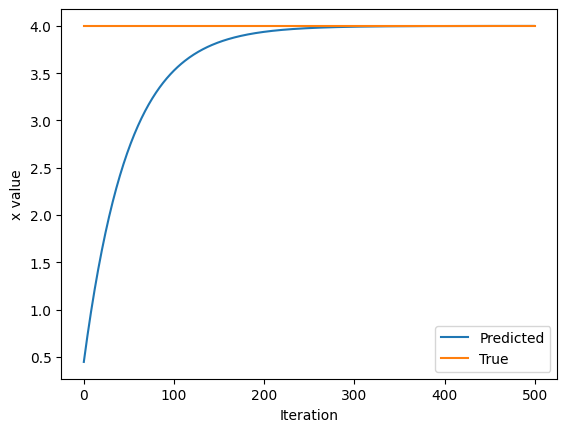

In [5]:
### Function minimization with automatic differentiation and SGD ###

# Initialize a random value for our initial x
x = tf.Variable([tf.random.normal([1])])
print("Initializing x={}".format(x.numpy()))

learning_rate = 1e-2 # learning rate for SGD
history = []
# Define the target value
x_f = 4

# We will run SGD for a number of iterations. At each iteration, we compute the loss,
#   compute the derivative of the loss with respect to x, and perform the SGD update.
for i in range(500):
  with tf.GradientTape() as tape:
    '''TODO: define the loss as described above'''
    loss = tf.subtract(x, x_f)*tf.subtract(x, x_f)

  # loss minimization using gradient tape
  grad = tape.gradient(loss, x) # compute the derivative of the loss with respect to x
  new_x = x - learning_rate*grad # sgd update
  x.assign(new_x) # update the value of x
  history.append(x.numpy()[0])

# Plot the evolution of x as we optimize towards x_f!
plt.plot(history)
plt.plot([0, 500],[x_f,x_f])
plt.legend(('Predicted', 'True'))
plt.xlabel('Iteration')
plt.ylabel('x value')

GradientTape provides an extremely flexible framework for automatic differentiation. In order to back propagate errors through a neural network, we track forward passes on the Tape, use this information to determine the gradients, and then use these gradients for optimization using SGD.